### Scheduling simulation visualization

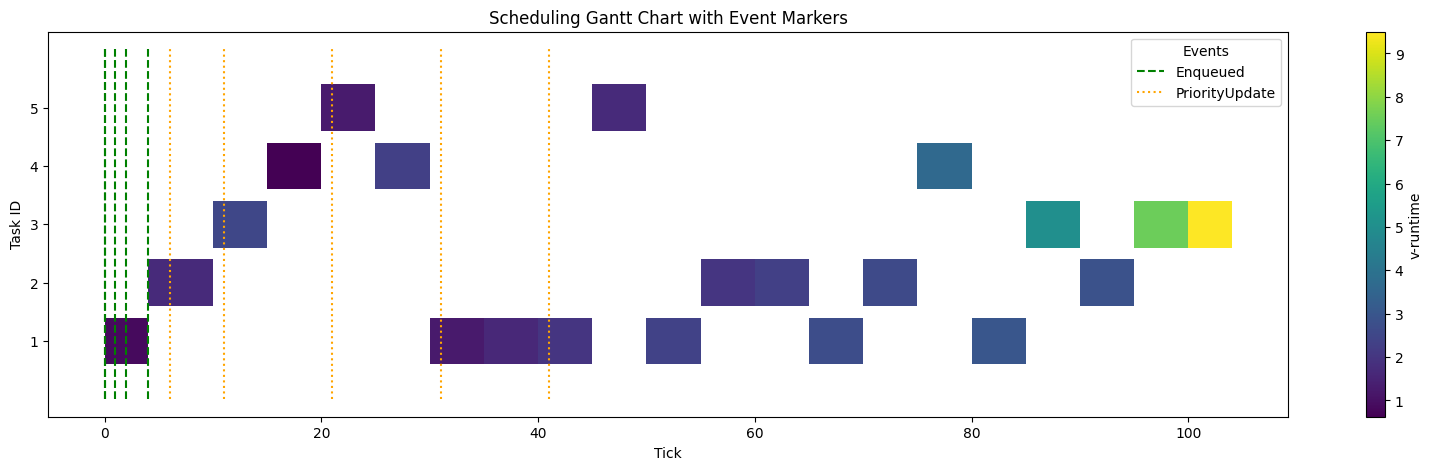

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

# Load data
df = pd.read_csv('scheduling.csv')

# Compute Gantt intervals from Dispatch => Preempt/Finish
dispatches = df[df['event'] == 'Dispatch']
intervals = []
for idx, start in dispatches.iterrows():
    tid = start['task_id']
    # find next Preempt/Finish
    next_evt = df[
        (df['task_id']==tid) &
        (df.index>idx) &
        (df['event'].isin(['Preempt','Finish']))
    ]
    if next_evt.empty: continue
    end_evt = next_evt.iloc[0]

    start_tick = start['tick']
    duration   = end_evt['tick'] - start_tick
    vr         = end_evt['vruntime']
    intervals.append((tid, start_tick, duration, vr))

# Normalize v-runtime for coloring
vr_values = [iv[3] for iv in intervals]
norm = mpl.colors.Normalize(vmin=min(vr_values), vmax=max(vr_values))
cmap = plt.cm.viridis

# Event styles for Enqueued and PriorityUpdate
event_styles = {
    'Enqueued':    {'color': 'green',  'linestyle': '--'},
    'PriorityUpdate': {'color': 'orange', 'linestyle': ':'}
}

# Create wide figure
fig, ax = plt.subplots(figsize=(20, 5))

# Plot Gantt bars
for tid, start, duration, vr in intervals:
    ax.broken_barh(
        [(start, duration)],
        (tid - 0.4, 0.8),
        facecolors=cmap(norm(vr))
    )

# Overlay event markers
min_y, max_y = min(df['task_id']) - 1, max(df['task_id']) + 1
for evt, style in event_styles.items():
    ticks = df[df['event'] == evt]['tick']
    ax.vlines(
        x=ticks,
        ymin=min_y,
        ymax=max_y,
        **style
    )

# Construct custom legend for events
legend_handles = [
    Line2D([0], [0],
           color=style['color'],
           linestyle=style['linestyle'],
           label=evt)
    for evt, style in event_styles.items()
]
ax.legend(
    handles=legend_handles,
    title='Events',
    loc='upper right'
)

# Labels and ticks
ax.set_xlabel('Tick')
ax.set_ylabel('Task ID')
ax.set_yticks(sorted({iv[0] for iv in intervals}))
ax.set_title('Scheduling Gantt Chart with Event Markers')

# Colorbar for v-runtime
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(vr_values)
fig.colorbar(sm, ax=ax, label='v-runtime')

plt.show()

